In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms

In [2]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device) My laptop uses cpu
torch.manual_seed(2023)

#Download MNIST dataset in local system
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
                ]),
#    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
                ]),
)


Batch size is 100

In [3]:
torch.manual_seed(2023)

def get_data(train_batch, test_batch):
    loaders = {
    'train' :   torch.utils.data.DataLoader(train_data,
                                            batch_size = train_batch,
                                            shuffle=True
                                           ),
    'test'  :   torch.utils.data.DataLoader(test_data,
                                            batch_size = test_batch,
                                            shuffle=True
                                            )
    }
    return loaders

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.fc1 = nn.Linear(32 * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x   # return x for visualization

In [5]:
def sensitivity(model):
    fNormAll = 0
    counter = 0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = p.grad
            fNorm = torch.linalg.norm(grad).numpy()
            fNormAll += fNorm
            counter += 1
    return fNormAll / counter

In [6]:
def calc_loss_acc(model, loader, loss_func):
    correct = 0
    total = 0
    loss_total = 0
    Count = 0
    with torch.no_grad():
        for batch in loader:
            image, label = batch
            output = model(image)
            loss = loss_func(output, label)
            loss_total +=loss
            Count +=1
            for i, out_y in enumerate(output):
                if torch.argmax(out_y) == label[i]:
                    correct +=1
                total +=1
    return loss_total / Count, round(correct/total, 3) # Return the loss and accuracy.

In [7]:
def train(model, optimizer, loaders, loss_func):
    model.train()
    for i, (image, label) in enumerate(loaders):
            b_x = Variable(image)
            b_y = Variable(label)
            optimizer.zero_grad()
            # or use data, target = Variable(images), Variable(labels)
            output = model(b_x)

            loss = loss_func(output, b_y)
            loss.backward()
            optimizer.step()

In [8]:
def set_optimizer(model, learning_rate):
    return torch.optim.Adam(model.parameters(), lr = learning_rate)

In [9]:
Loss_arr = []
Acc_arr = []

def get_result(model, loaders, optimizer, epoch_num):
    loss_func = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epoch_num + 1):
        train(model, optimizer, loaders['train'], loss_func)
        Train_loss, Train_acc = calc_loss_acc(model, loaders['train'], loss_func)
        Test_loss, Test_acc = calc_loss_acc(model, loaders['test'], loss_func)
    Loss_arr.append([Train_loss, Test_loss])
    Acc_arr.append([Train_acc, Test_acc])
    print("Model Train loss: ", Train_loss)
    print("Model Test loss: ", Test_loss)


In [10]:
batch_size = [100, 300, 500, 1000, 2500, 5000, 10000]

In [11]:
S = []
for batch in batch_size:
    torch.manual_seed(2023)
    loss_func = torch.nn.CrossEntropyLoss()
    loaders = get_data(batch, batch)
    model1 = CNN()
    optimizer = set_optimizer(model1, 0.001)
    epoch_num = 15
    get_result(model1, loaders, optimizer, epoch_num)
    S.append(sensitivity(model1))


Model Train loss:  tensor(0.0067)
Model Test loss:  tensor(0.0418)
Model Train loss:  tensor(0.0131)
Model Test loss:  tensor(0.0307)
Model Train loss:  tensor(0.0198)
Model Test loss:  tensor(0.0287)
Model Train loss:  tensor(0.0321)
Model Test loss:  tensor(0.0343)
Model Train loss:  tensor(0.0523)
Model Test loss:  tensor(0.0481)
Model Train loss:  tensor(0.0908)
Model Test loss:  tensor(0.0824)
Model Train loss:  tensor(0.1885)
Model Test loss:  tensor(0.1735)


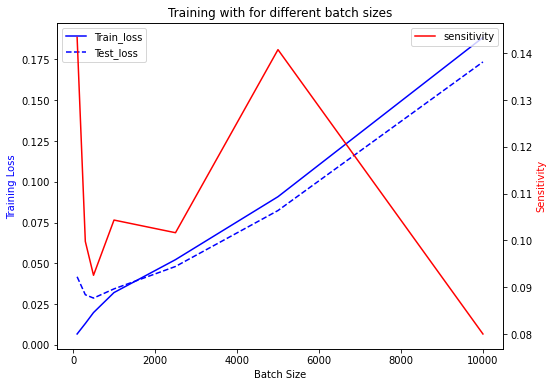

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
Loss_arr = np.array(Loss_arr)

plt.plot(batch_size, Loss_arr[:,0], label = 'Train_loss', color = 'blue')
plt.plot(batch_size, Loss_arr[:,1], label = 'Test_loss', color = 'blue', linestyle = 'dashed')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Training Loss', color = 'blue')

plt.twinx()
plt.plot(batch_size, S, label = 'sensitivity', color = 'red')
plt.title('Training with for different batch sizes')
plt.ylabel('Sensitivity', color = 'red')
plt.legend()
plt.show()

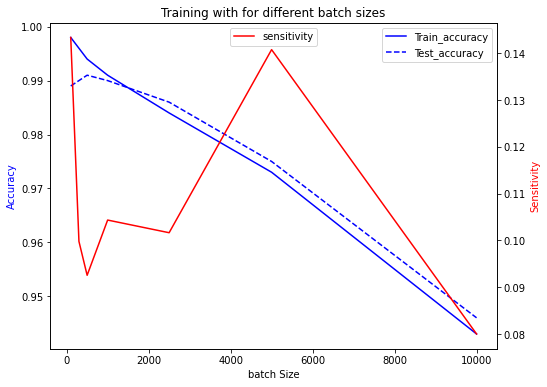

In [25]:
fig = plt.figure(figsize=(8, 6))
Acc_arr = np.array(Acc_arr)
plt.plot(batch_size, Acc_arr[:,0], label = 'Train_accuracy', color = 'blue')
plt.plot(batch_size, Acc_arr[:,1], label = 'Test_accuracy', color = 'blue', linestyle = 'dashed')
plt.legend()
plt.xlabel('batch Size')
plt.ylabel('Accuracy', color = 'blue')

plt.twinx()
plt.plot(batch_size, S, label = 'sensitivity', color = 'red')
plt.title('Training with for different batch sizes')
plt.ylabel('Sensitivity', color = 'red')
plt.legend(loc = 'upper center')
plt.show()